In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

dataset_dir =  '/content/drive/MyDrive/flowers-recognition'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False

def extract_features(generator):
    features, labels = [], []
    for _ in range(generator.samples // generator.batch_size):
        imgs, lbls = next(generator)
        feature = vgg_model.predict(imgs)
        feature = feature.reshape(feature.shape[0], -1)
        features.append(feature)
        labels.append(lbls)

    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

train_features, train_labels = extract_features(train_generator)
test_features, test_labels = extract_features(test_generator)
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

model = Sequential([
    Dense(1024, activation='relu', input_shape=(train_features.shape[1],)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_features, train_labels,
    validation_data=(test_features, test_labels),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

_, test_accuracy = model.evaluate(test_features, test_labels)
print(f"Точность нейросетевого классификатора: {test_accuracy:.4f}")

# plt.figure(figsize=(12, 6))
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()




Found 200 images belonging to 6 classes.
Found 52 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.1901 - loss: 2.1734 - val_accuracy: 0.3750 - val_loss: 1.5412
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3515 - loss: 1.7862 - val_accuracy: 0.5312 - val_loss: 1.3724
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4394 - loss: 1.5244 - val_accuracy: 0.5938 - val_loss: 1.2093
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4696 - loss: 1.4653 - val_accuracy: 0.5938 - val_loss: 1.1284
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6405 - loss: 1.1455 - val_accuracy: 0.6562 - val_loss: 1.0575
Epoch 6/20
6/6 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


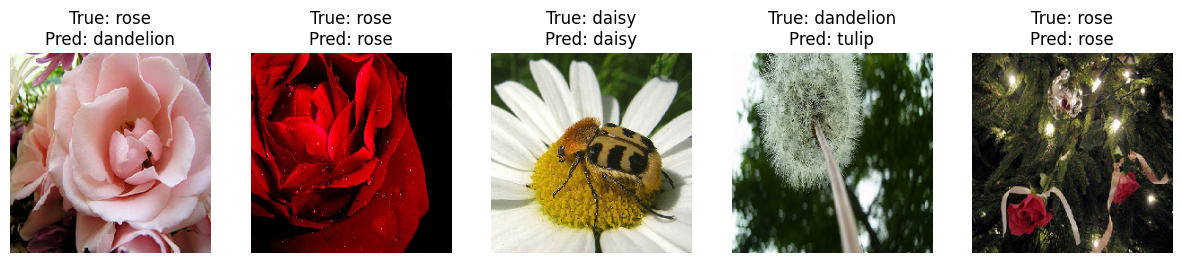

In [24]:

def visualize_predictions(generator, features, model, n_samples=5):
    imgs, lbls = next(generator)
    preds = model.predict(features[:n_samples])
    preds = np.argmax(preds, axis=1)
    true_labels = np.argmax(lbls[:n_samples], axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(imgs[i])
        plt.title(f"True: {list(generator.class_indices.keys())[true_labels[i]]}\n"
                  f"Pred: {list(generator.class_indices.keys())[preds[i]]}")
        plt.axis('off')
    plt.show()

visualize_predictions(test_generator, test_features, model)